# 1. Import thư viện

In [1]:
import numpy as np
from pathlib import Path
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Các hằng số 

In [2]:
DATA_DIR = Path("../data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

# 3. Load dữ liệu raw

## Giới thiệu về dữ liệu

Dữ liêu được chọn là "Credit Card Fraud Detection" lấy từ [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data).
- Dữ liệu chứa thông tin của các giao dịch sử dụng thẻ tín dụng trong năm 2013.
    - Các cột "V1"-"V28" là kết quả của PCA, riêng cột "Time" và cột "Amount" chưa được thông qua PCA.
    - Cột "Time" chứa thời gian giữa giao dịch với giao dịch đầu tiên (giây).
    - Cột "Amount chứa thông tin về số tiền giao dịch.
    - Cột "Class" cho biết giao dịch đó có phải gian lận hay không (1 nếu có, 0 nếu không phải).
- Dữ liệu được cho biết có sự mất cân bằng lớp.

In [3]:
file = open(RAW_DATA_DIR / "creditcard.csv", "r", encoding="utf-8")

cols = {}
pattern = re.compile(r"""((?:[^,"']|"[^"]*"|'[^']*')+)""")

first_line = file.readline()
entries = pattern.findall(first_line.strip())

for entry in entries:
    cols[entry] = []

for line in file:
    entries = pattern.findall(line.strip())

    for i, entry in enumerate(entries):
        key = list(cols.keys())[i]
        cols[key].append(entry)

# 4. EDA

## 4.1 Kiểm tra dữ liệu

In [4]:
# Kiểm tra số cột và số dòng

num_of_columns = len(cols)
num_of_rows = len(cols[list(cols.keys())[0]])

print(f"Số cột: {num_of_columns}")
print(f"Số dòng: {num_of_rows}")

Số cột: 31
Số dòng: 284807


In [5]:
# Kiểm tra kiểu dữ liệu

for key in cols.keys():
    sample_value = cols[key][0]
    try:
        float(sample_value)
        dtype = "float"
    except ValueError:
        dtype = "string"

    print(f"Cột '{key}' có kiểu dữ liệu: {dtype}")

# Chắc chắn tất cả các dòng có cùng kiểu dữ liệu trong mỗi cột

for key in cols.keys():
    sample_value = cols[key][0]
    is_float_column = False
    try:
        float(sample_value)
        is_float_column = True
    except ValueError:
        is_float_column = False

    for value in cols[key]:
        if is_float_column:
            try:
                float(value)
            except ValueError:
                print(f"Lỗi: Cột '{key}' có giá trị không phải số: {value}")
        else:
            pass

Cột '"Time"' có kiểu dữ liệu: float
Cột '"V1"' có kiểu dữ liệu: float
Cột '"V2"' có kiểu dữ liệu: float
Cột '"V3"' có kiểu dữ liệu: float
Cột '"V4"' có kiểu dữ liệu: float
Cột '"V5"' có kiểu dữ liệu: float
Cột '"V6"' có kiểu dữ liệu: float
Cột '"V7"' có kiểu dữ liệu: float
Cột '"V8"' có kiểu dữ liệu: float
Cột '"V9"' có kiểu dữ liệu: float
Cột '"V10"' có kiểu dữ liệu: float
Cột '"V11"' có kiểu dữ liệu: float
Cột '"V12"' có kiểu dữ liệu: float
Cột '"V13"' có kiểu dữ liệu: float
Cột '"V14"' có kiểu dữ liệu: float
Cột '"V15"' có kiểu dữ liệu: float
Cột '"V16"' có kiểu dữ liệu: float
Cột '"V17"' có kiểu dữ liệu: float
Cột '"V18"' có kiểu dữ liệu: float
Cột '"V19"' có kiểu dữ liệu: float
Cột '"V20"' có kiểu dữ liệu: float
Cột '"V21"' có kiểu dữ liệu: float
Cột '"V22"' có kiểu dữ liệu: float
Cột '"V23"' có kiểu dữ liệu: float
Cột '"V24"' có kiểu dữ liệu: float
Cột '"V25"' có kiểu dữ liệu: float
Cột '"V26"' có kiểu dữ liệu: float
Cột '"V27"' có kiểu dữ liệu: float
Cột '"V28"' có kiểu dữ liệu:

In [6]:
# Kiểm tra nếu có giá trị thiếu

missing_values = {}
for key, values in cols.items():
    missing_count = sum(
        1 for v in values if v == "" or v.lower() == "na" or v.lower() == "null"
    )
    missing_values[key] = missing_count

print("Giá trị thiếu theo cột:")
for key, count in missing_values.items():
    print(f"{key}: {count}")

Giá trị thiếu theo cột:
"Time": 0
"V1": 0
"V2": 0
"V3": 0
"V4": 0
"V5": 0
"V6": 0
"V7": 0
"V8": 0
"V9": 0
"V10": 0
"V11": 0
"V12": 0
"V13": 0
"V14": 0
"V15": 0
"V16": 0
"V17": 0
"V18": 0
"V19": 0
"V20": 0
"V21": 0
"V22": 0
"V23": 0
"V24": 0
"V25": 0
"V26": 0
"V27": 0
"V28": 0
"Amount": 0
"Class": 0


## 4.2 Thống kê mô tả

In [7]:
for key, values in cols.items():
    try:
        numeric_values = [float(v) for v in values]
        mean = np.mean(numeric_values)
        median = np.median(numeric_values)
        std_dev = np.std(numeric_values)
        min_val = np.min(numeric_values)
        max_val = np.max(numeric_values)

        print(f"Thống kê mô tả cho cột '{key}':")
        print(f"  Trung bình: {mean}")
        print(f"  Trung vị: {median}")
        print(f"  Độ lệch chuẩn: {std_dev}")
        print(f"  Giá trị nhỏ nhất: {min_val}")
        print(f"  Giá trị lớn nhTimeất: {max_val}")
    except ValueError:
        pass

Thống kê mô tả cho cột '"Time"':
  Trung bình: 94813.85957508067
  Trung vị: 84692.0
  Độ lệch chuẩn: 47488.062585499334
  Giá trị nhỏ nhất: 0.0
  Giá trị lớn nhTimeất: 172792.0
Thống kê mô tả cho cột '"V1"':
  Trung bình: 1.1683749838001528e-15
  Trung vị: 0.0181087991615309
  Độ lệch chuẩn: 1.9586923652174186
  Giá trị nhỏ nhất: -56.407509631329
  Giá trị lớn nhTimeất: 2.45492999121121
Thống kê mô tả cho cột '"V2"':
  Trung bình: 3.416908049651284e-16
  Trung vị: 0.0654855563960555
  Độ lệch chuẩn: 1.6513056804786777
  Giá trị nhỏ nhất: -72.7157275629303
  Giá trị lớn nhTimeất: 22.0577289904909
Thống kê mô tả cho cột '"V3"':
  Trung bình: -1.379536707896593e-15
  Trung vị: 0.179846343563544
  Độ lệch chuẩn: 1.5162523432763155
  Giá trị nhỏ nhất: -48.3255893623954
  Giá trị lớn nhTimeất: 9.38255843282114
Thống kê mô tả cho cột '"V4"':
  Trung bình: 2.0740951198584196e-15
  Trung vị: -0.0198465294811989
  Độ lệch chuẩn: 1.4158660892755086
  Giá trị nhỏ nhất: -5.68317119816995
  Giá trị

### Nhận xét

- Các trường "V1"–"V28" đều có giá trị trung bình gần 0, độ lệch chuẩn lớn hơn 1, cho thấy dữ liệu đã được chuẩn hóa hoặc biến đổi đặc trưng.
- Một số trường có giá trị nhỏ nhất và lớn nhất rất lớn (ví dụ "V5", "V7", "V8", "V20", "V21", "V23", "V27", "V28"), có thể xuất hiện outlier hoặc giao dịch bất thường.
- Cột "Amount" có giá trị trung bình khá nhỏ so với giá trị lớn nhất, cho thấy phần lớn giao dịch có số tiền nhỏ, chỉ một số ít giao dịch có số tiền rất lớn.
- Trường "Time" trải dài từ 0 đến 172792, trung bình và trung vị khá cao, cho thấy dữ liệu được thu thập trong một khoảng thời gian dài.
- Các trường số đều có độ lệch chuẩn lớn hơn 0, chứng tỏ dữ liệu đa dạng và có sự phân tán rõ rệt.

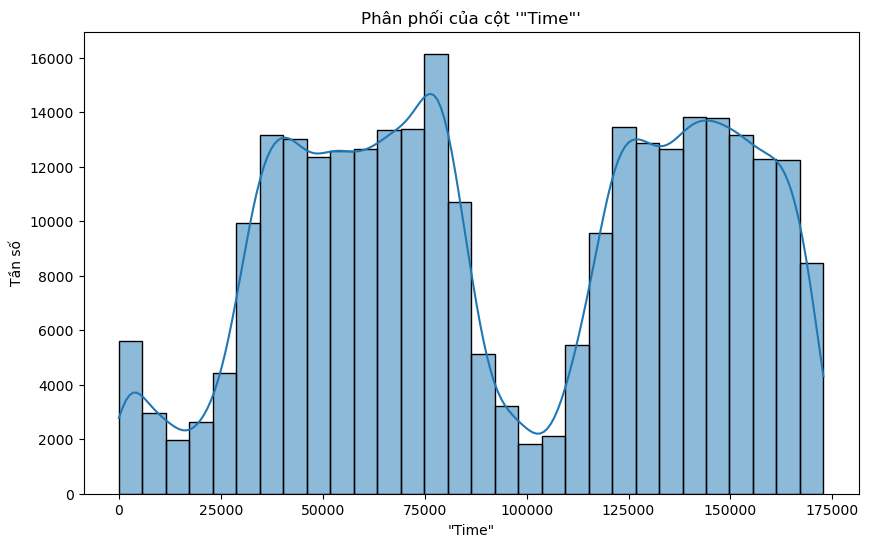

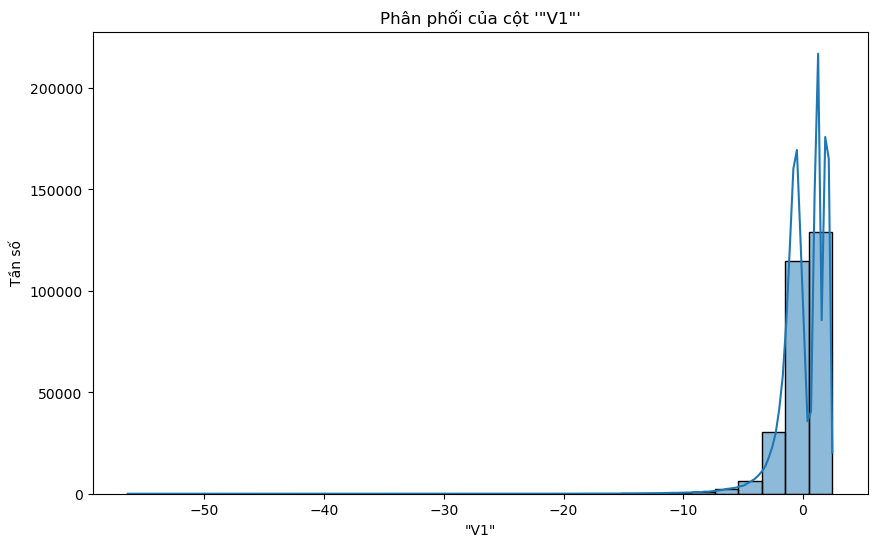

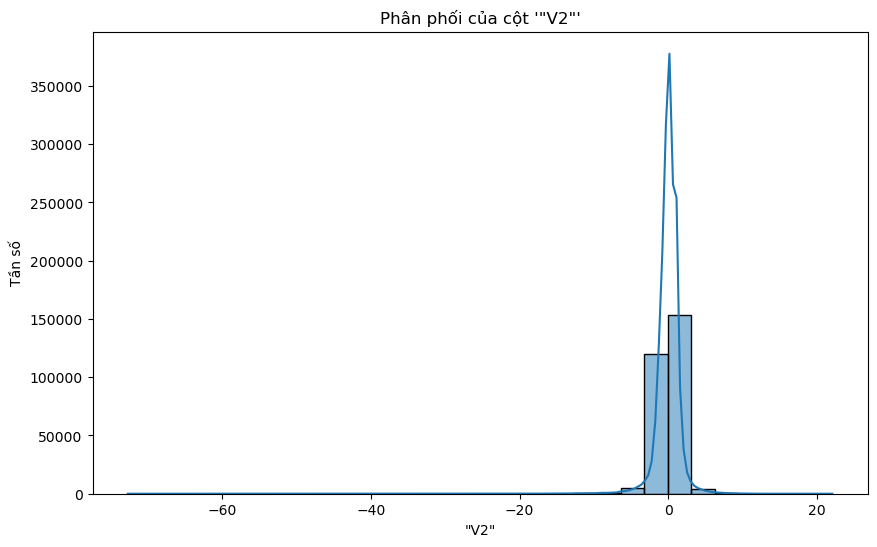

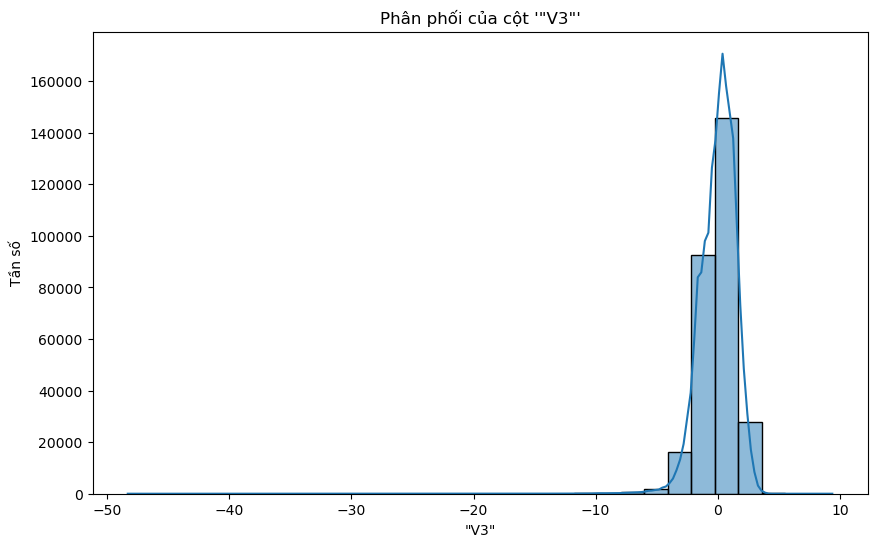

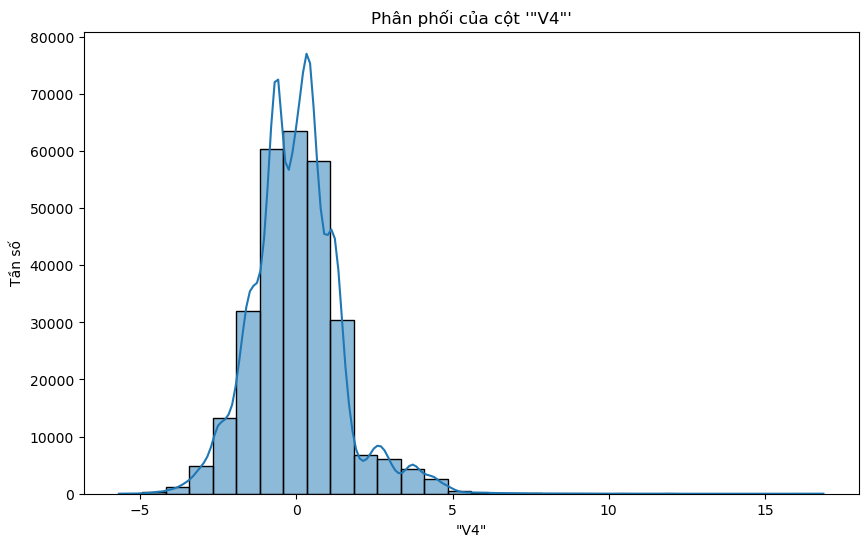

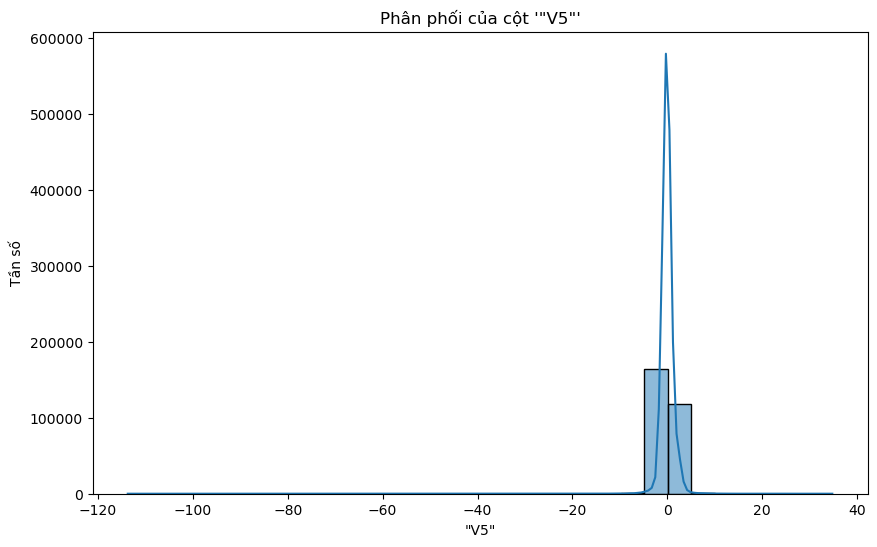

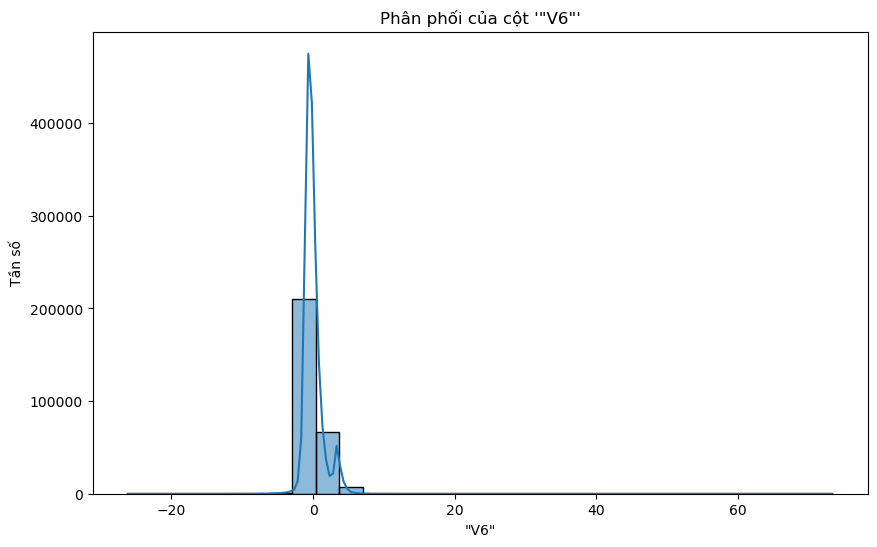

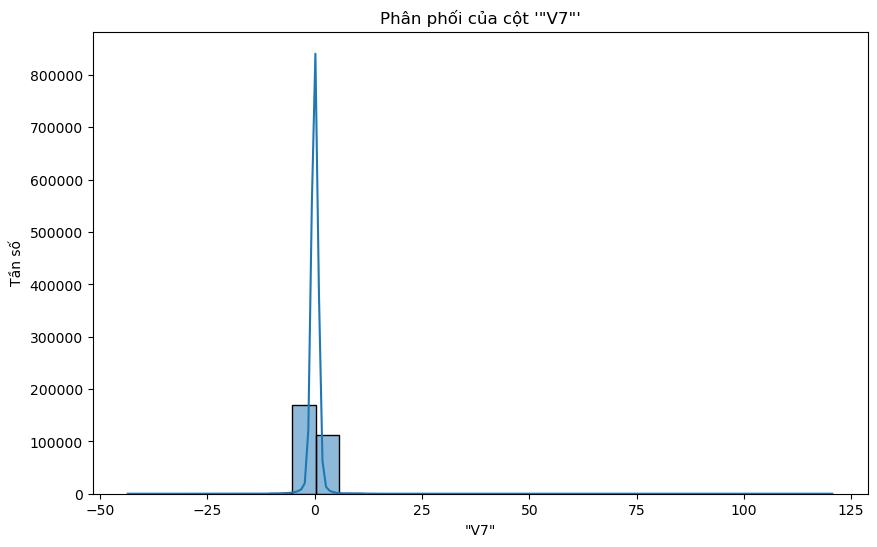

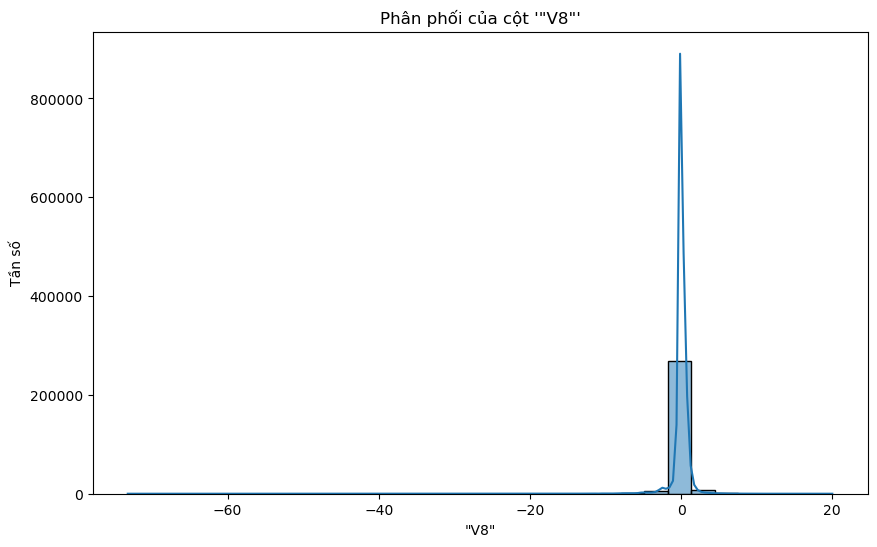

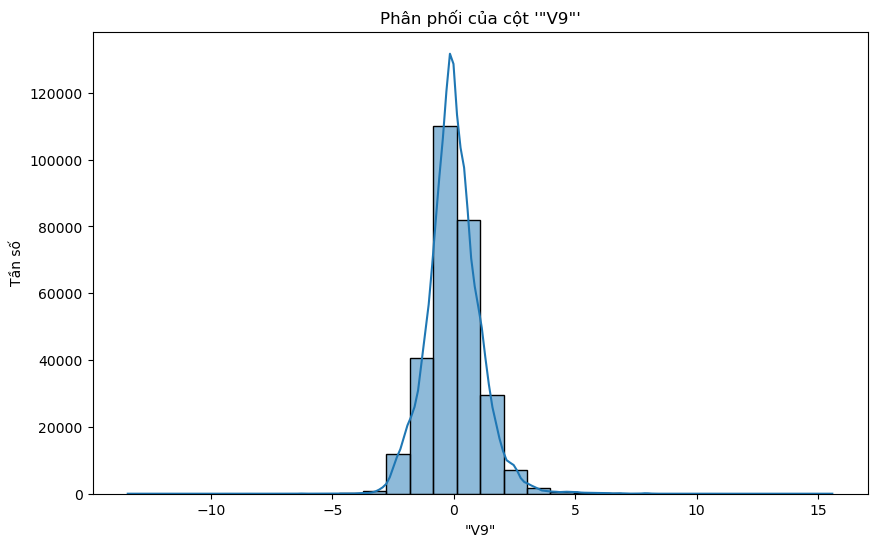

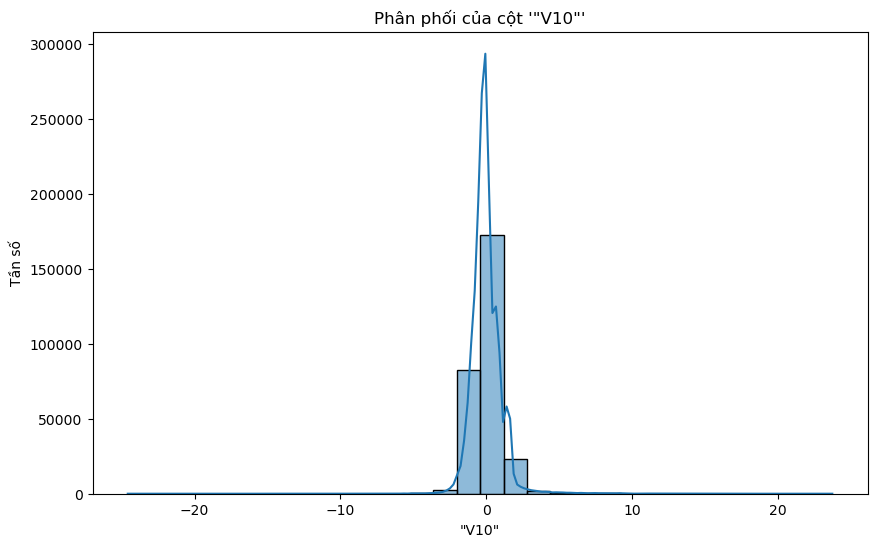

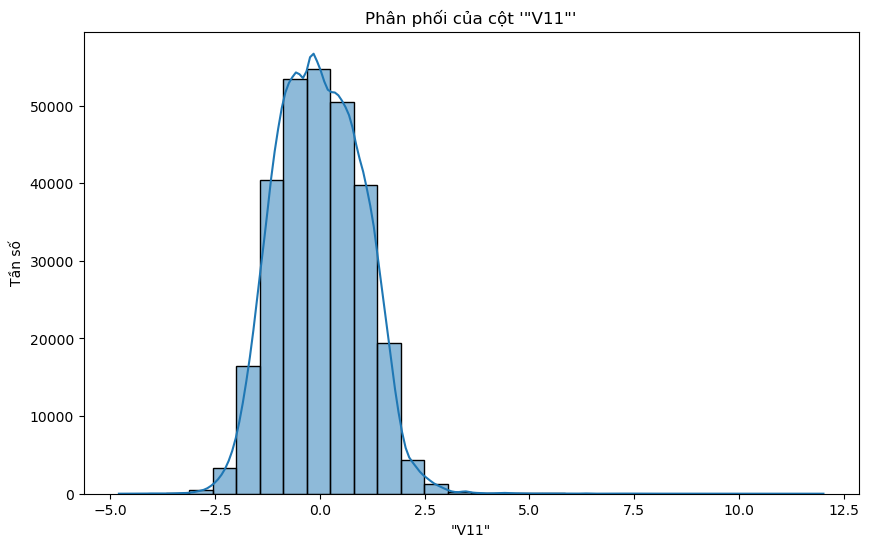

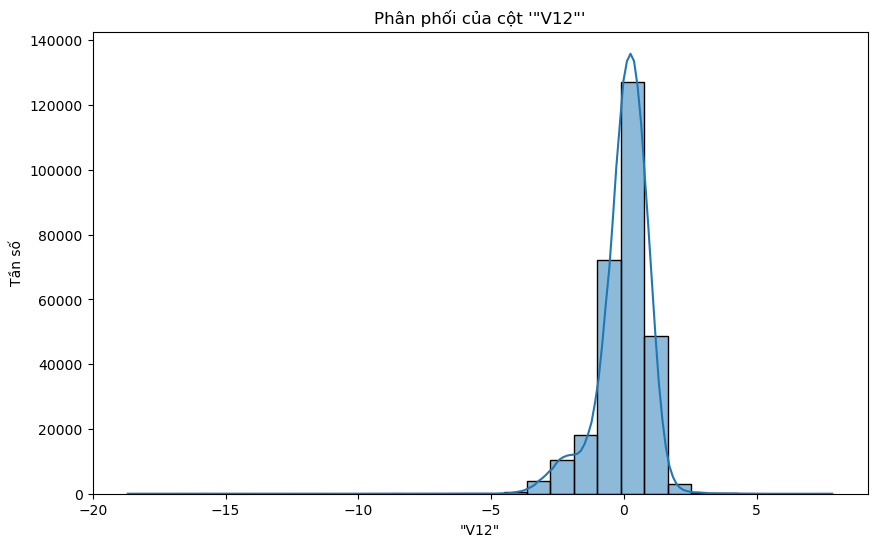

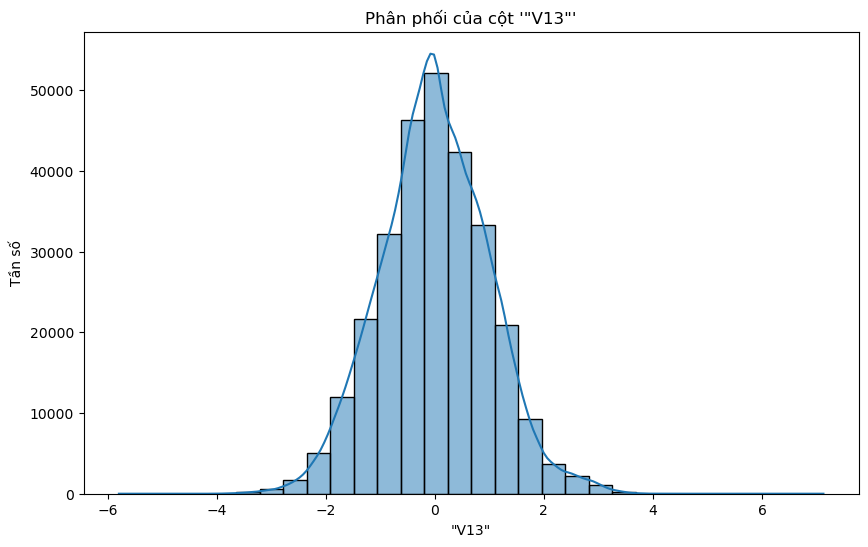

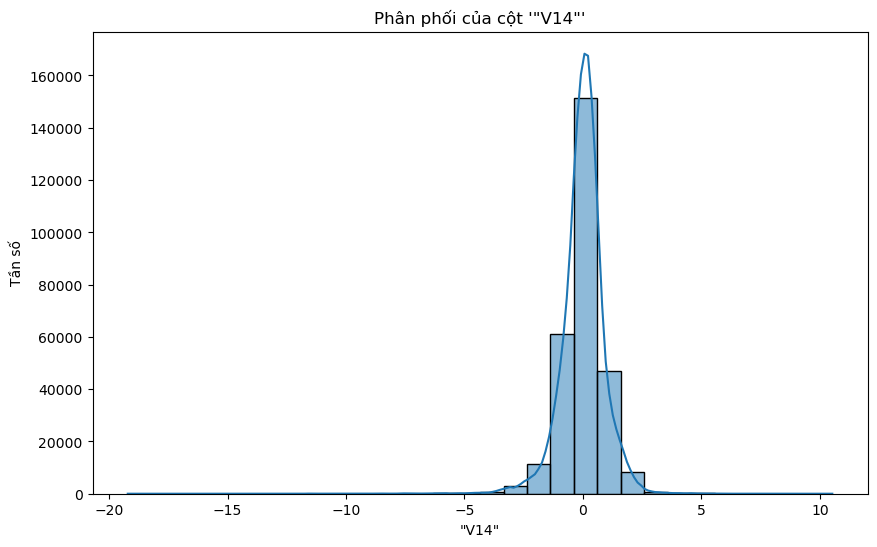

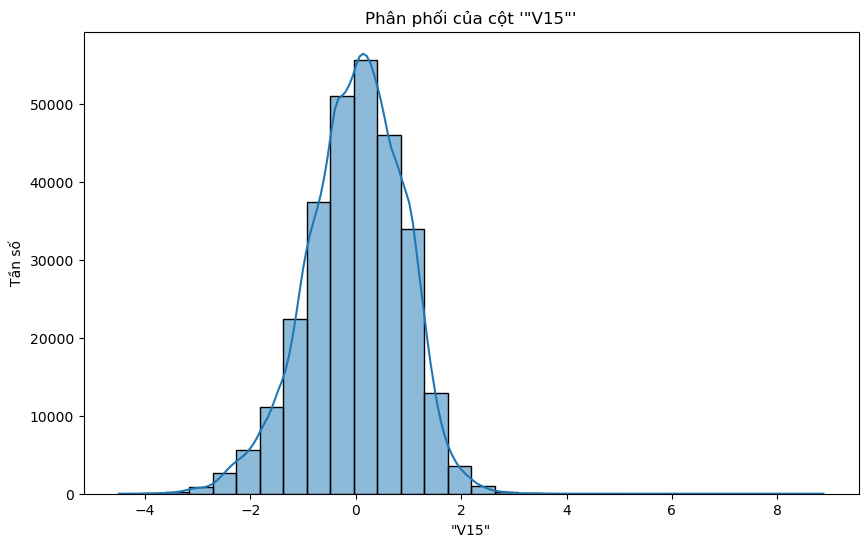

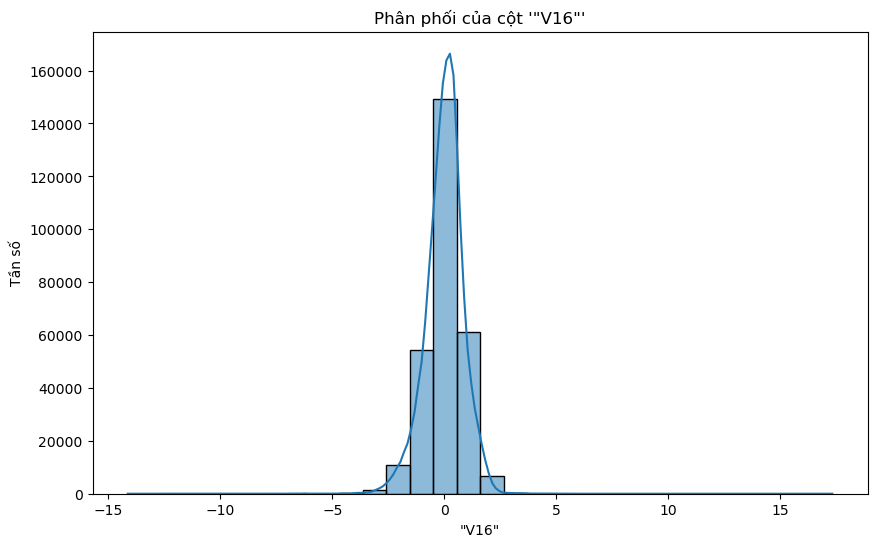

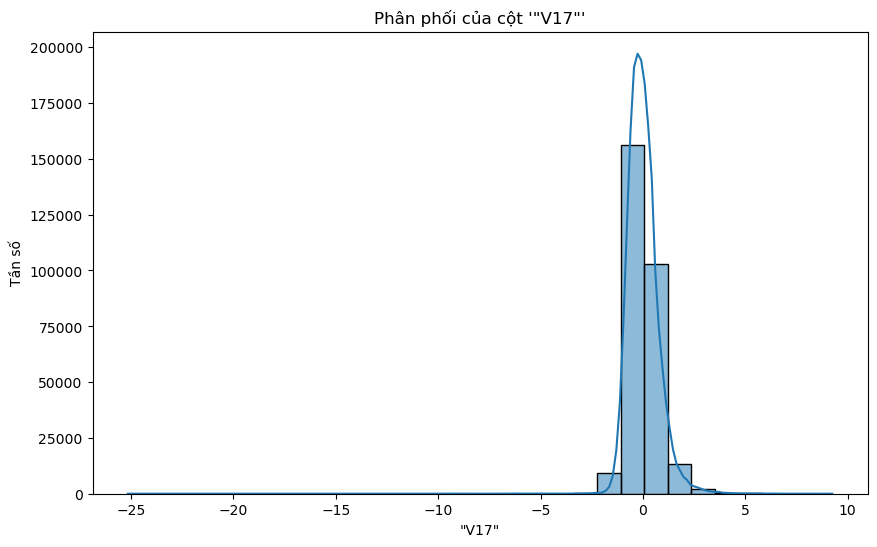

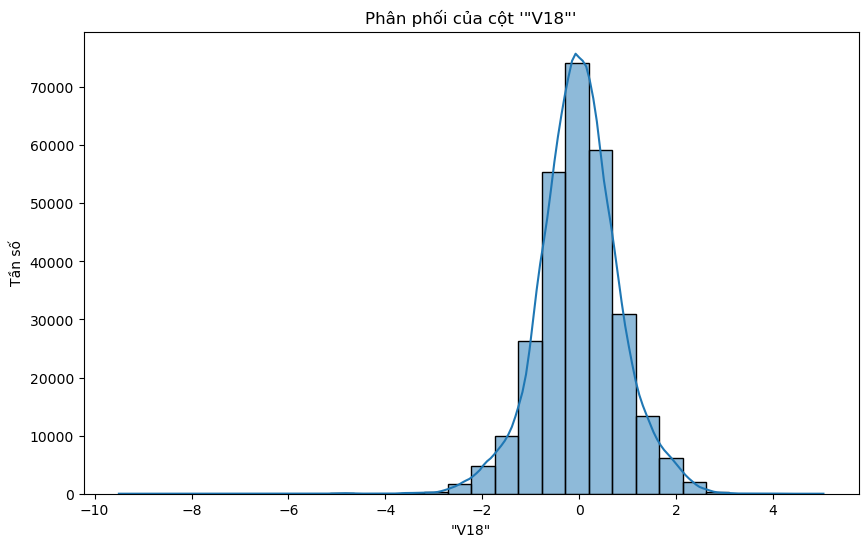

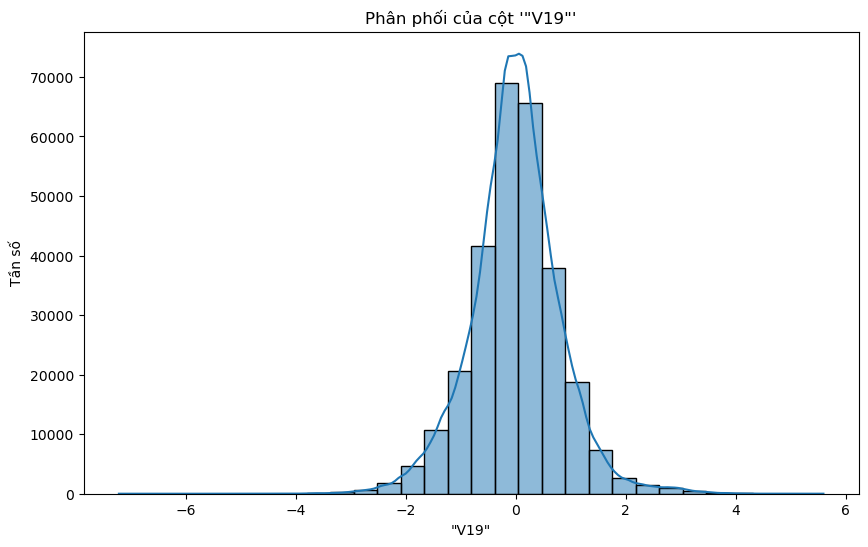

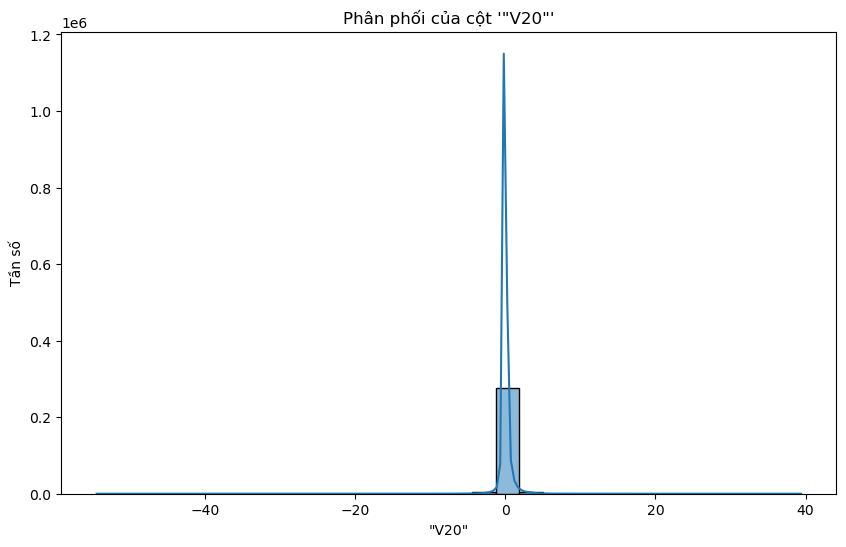

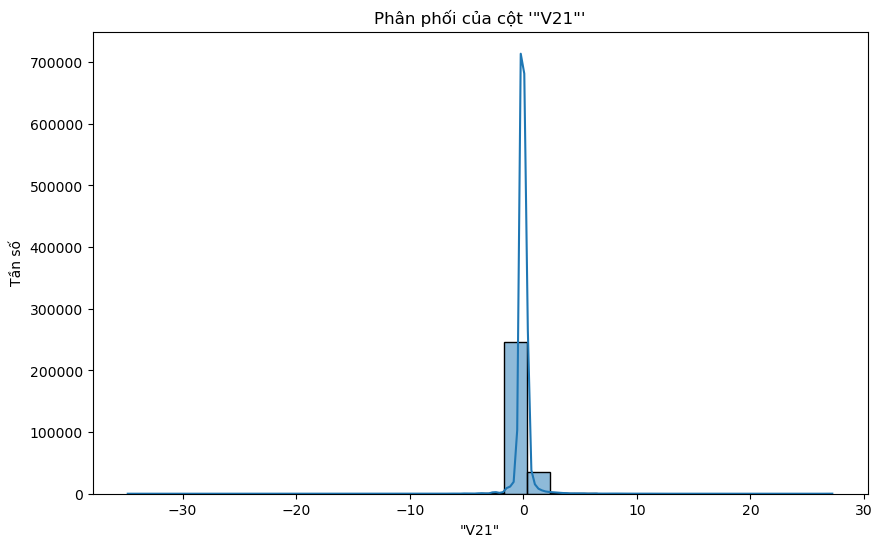

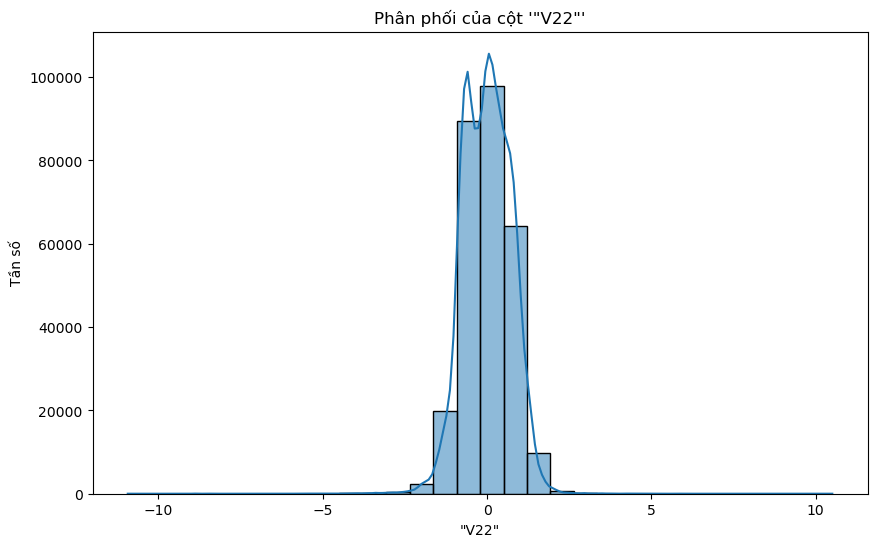

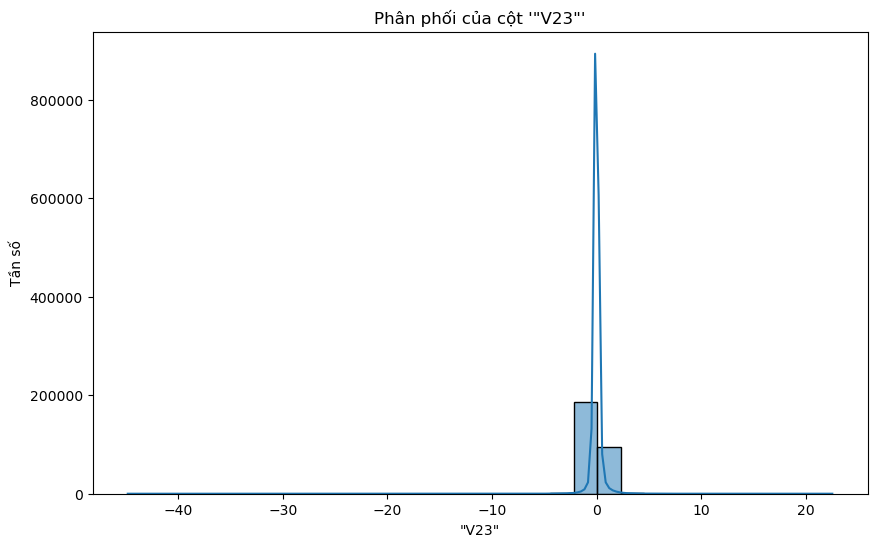

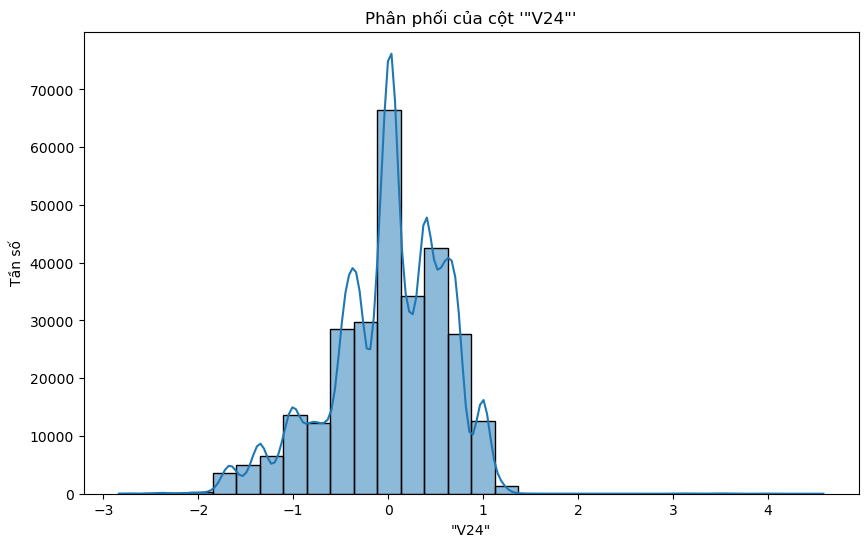

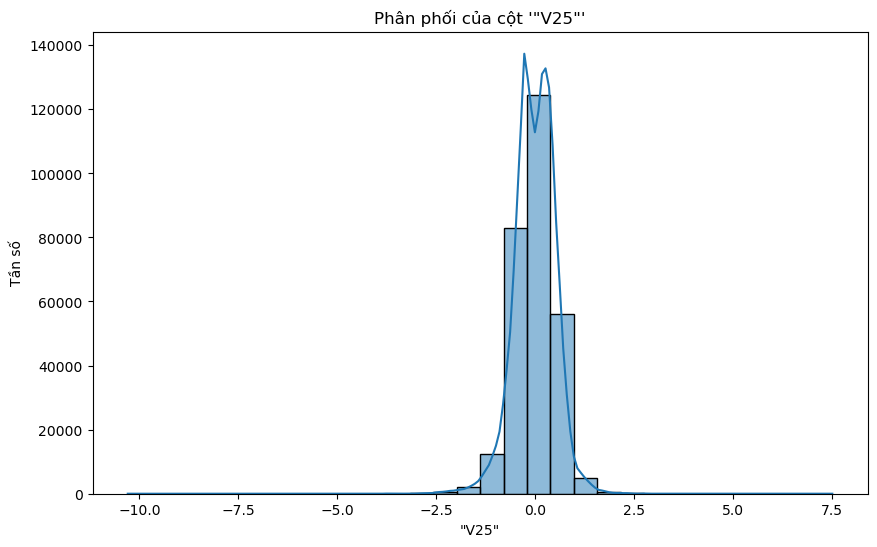

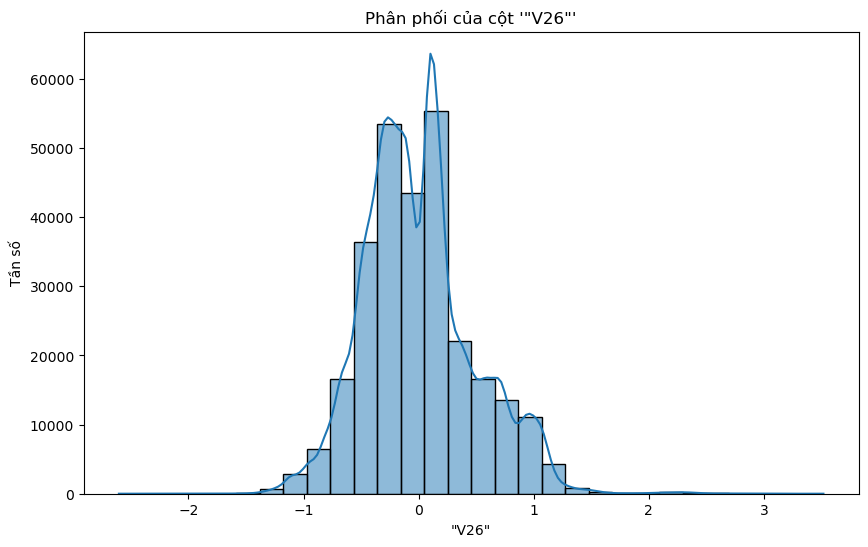

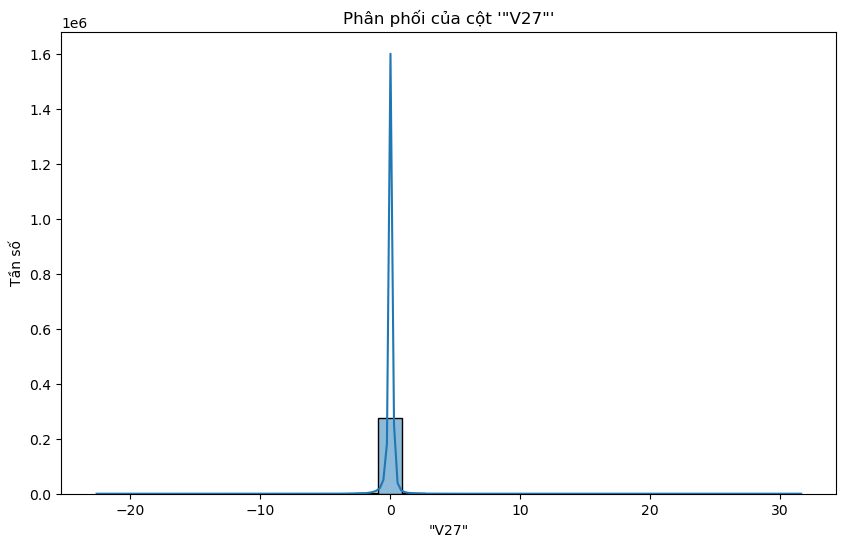

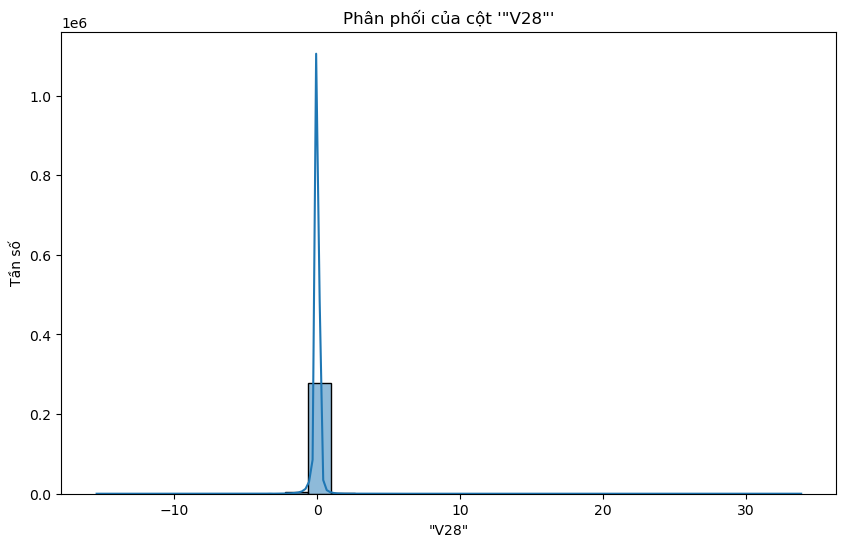

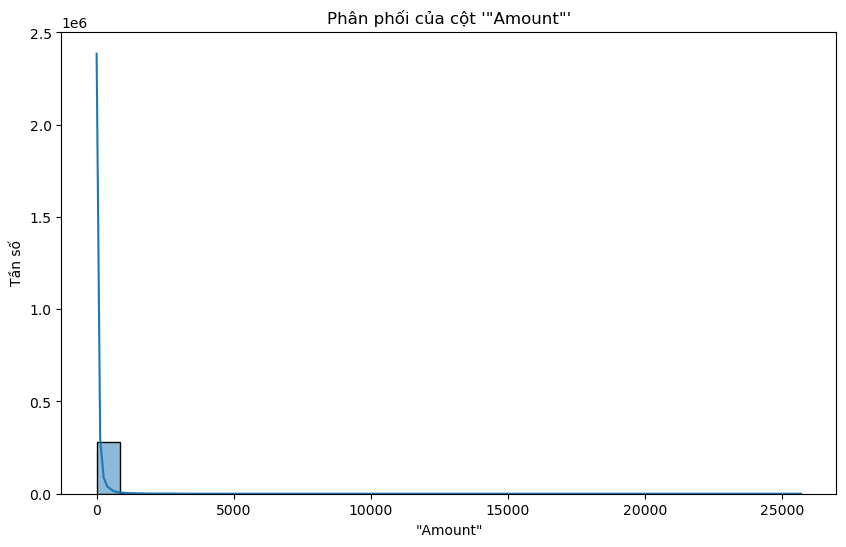

In [8]:
# kiểm tra phân phối của các cột số học bằng biểu đồ histogram

for key, values in cols.items():
    try:
        numeric_values = [float(v) for v in values]

        plt.figure(figsize=(10, 6))
        sns.histplot(numeric_values, bins=30, kde=True)
        plt.title(f"Phân phối của cột '{key}'")
        plt.xlabel(key)
        plt.ylabel("Tần số")
        plt.show()
    except ValueError:
        pass

### Nhận xét
- Gần như tất cả các cột "V1"-"V28" đều có phân phối gần chuẩn, tập trung quanh giá trị 0.
- Có các cột như "V1" có một số giá trị phía âm, nhưng phần lớn giá trị đều nằm gần trung tâm 0.
- Cột "Time": phân phối không chuẩn, có hai đỉnh rõ rệt, cho thấy dữ liệu dược thu thập theo hai giai đoạn hoặc phân bố không đều theo thời gian.
- Cột "Amount": phân phối lệch phải mạnh, cho thấy đa số giao dịch có số tiền nhỏ, chỉ có một số ít giao dịch có số tiền rất lớn.

In [9]:
# đếm tỉ lệ của các lớp trong cột "Class"

class_values = cols['"Class"']
class_counts = {}
for value in class_values:
    if value in class_counts:
        class_counts[value] += 1
    else:
        class_counts[value] = 1
print('Tỉ lệ các lớp trong cột "Class":')
for class_label, count in class_counts.items():
    print(
        f"Lớp {class_label}: {count} mẫu, chiếm {count / len(class_values) * 100:.4f}%"
    )

Tỉ lệ các lớp trong cột "Class":
Lớp "0": 284315 mẫu, chiếm 99.8273%
Lớp "1": 492 mẫu, chiếm 0.1727%


### Nhận xét
- Dữ liệu cực kì mất cân bằng: lớp "1" chỉ có 492 mẫu (chiếm 0.1727%), và lớp "0" có tới 284315 mẫu (chiếm 99.8273%) --> tỉ lệ giao dịch gian lận rất ít.
- Cần cân nhắc các kĩ thuật xử lí cho trường hợp bị mất cân bằng lớp.

## 4.3 Phân tích tương quan

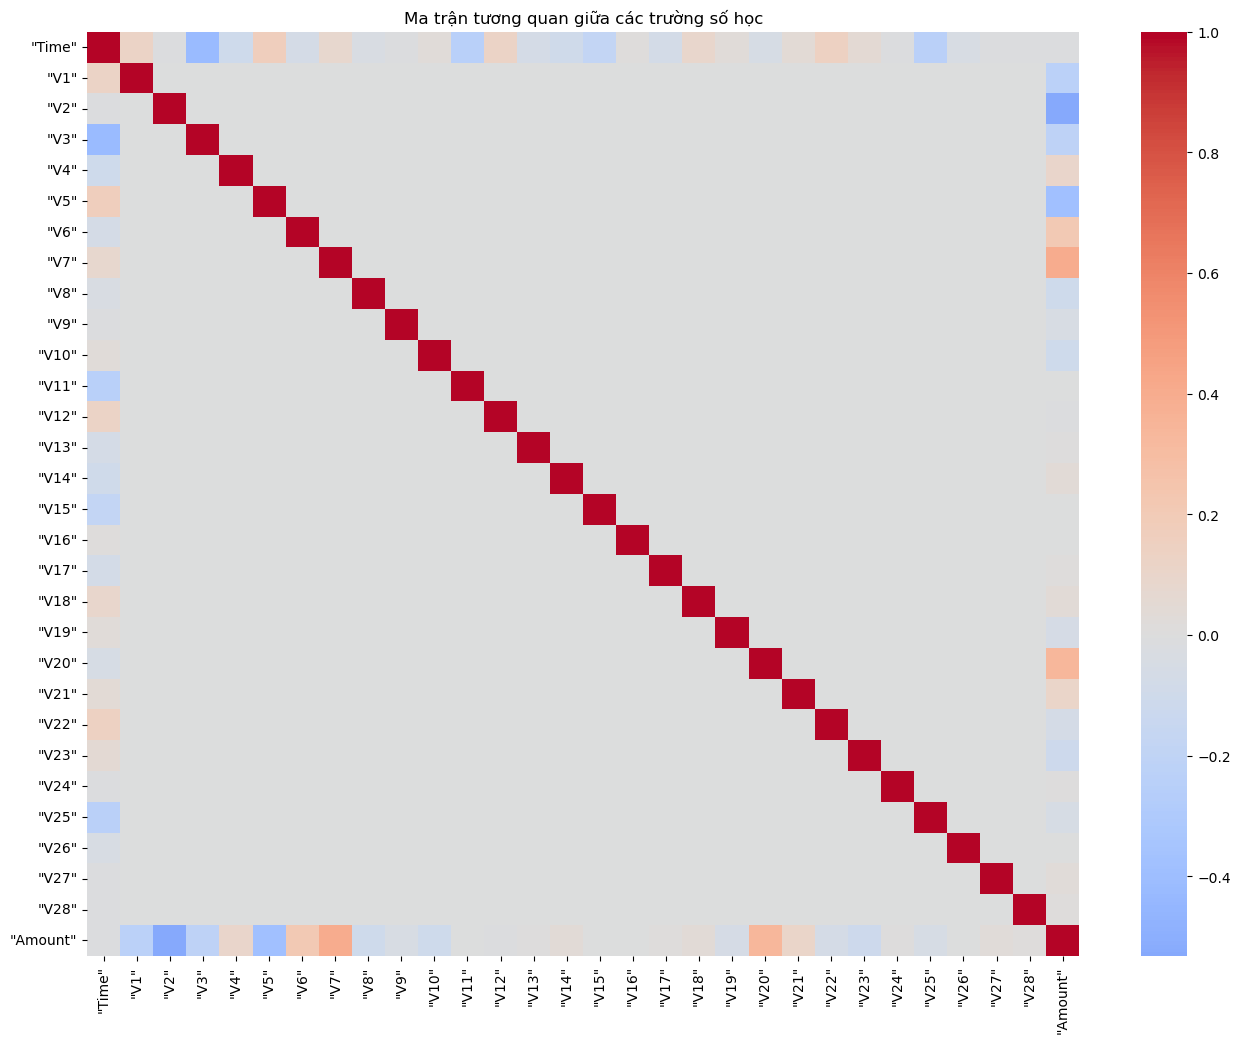

In [10]:
# phân tích ma trận tương quan giữa các trường số học

numeric_keys = [key for key in cols.keys() if key != '"Class"']

numeric_data = np.array(
    [
        [float(cols[key][i]) for key in numeric_keys]
        for i in range(len(cols[numeric_keys[0]]))
    ]
)

corr_matrix = np.corrcoef(numeric_data, rowvar=False)

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    xticklabels=numeric_keys,
    yticklabels=numeric_keys,
    cmap="coolwarm",
    center=0,
)

plt.title("Ma trận tương quan giữa các trường số học")
plt.show()

### Nhận xét
- Đa số các trường số học có tương quan rất thấp với nhau.
- Một số trường có tương quan dương hoăc âm nhẹ, nhưng đa phần không có sự nổi bật.

## 4.4 Phân tích giá trị ngoại lai

In [11]:
class_numeric = np.array([int(ast.literal_eval(v)) for v in cols['"Class"']])

correlations_with_class = {}
for i, key in enumerate(numeric_keys):
    field_values = numeric_data[:, i]
    correlation = np.corrcoef(field_values, class_numeric)[0, 1]
    correlations_with_class[key] = correlation

print('Tương quan giữa các trường số học và cột "Class":')
for key, corr in correlations_with_class.items():
    print(f"{key}: {corr}")

Tương quan giữa các trường số học và cột "Class":
"Time": -0.012322570929245642
"V1": -0.10134729859508508
"V2": 0.09128865034461915
"V3": -0.19296082706741322
"V4": 0.13344748623900432
"V5": -0.09497429899144809
"V6": -0.043643160699963775
"V7": -0.18725659151429797
"V8": 0.019875123914794363
"V9": -0.09773268607407871
"V10": -0.21688294364102725
"V11": 0.1548756447439473
"V12": -0.26059292487721686
"V13": -0.004569778799461258
"V14": -0.3025436958044044
"V15": -0.004223402267856669
"V16": -0.1965389403040179
"V17": -0.32648106724371434
"V18": -0.11148525388904092
"V19": 0.03478301303651474
"V20": 0.020090324196975373
"V21": 0.04041338061057561
"V22": 0.0008053175052984613
"V23": -0.002685155740250693
"V24": -0.007220906715952716
"V25": 0.0033077055972996414
"V26": 0.004455397501283351
"V27": 0.017579728189513248
"V28": 0.009536040916236166
"Amount": 0.005631753006768537


### Nhận xét
- Đa số các cột số học có tương quan rất thấp với "Class", giá trị tuyệt đối đều nhỏ hơn 0.35.
- Một số cột có tương quan âm rõ hơn như V10, V12, V14, V16, V17 (đặc biệt V17, V14, V12), có thể giúp phân biệt giao dịch gian lận.
- Các cột còn lại có tương quan gần như bằng 0, không đóng góp nhiều cho việc phân loại.
- "Amount" và "Time" có tương quan rất thấp với "Class", cho thấy số tiền và thời điểm giao dịch khôn

In [12]:
# Phân tích outlier cho các trường số học

for key in numeric_keys:
    numeric_values = np.array([float(v) for v in cols[key]])
    q1 = np.percentile(numeric_values, 25)
    q3 = np.percentile(numeric_values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = numeric_values[
        (numeric_values < lower_bound) | (numeric_values > upper_bound)
    ]
    print(f"Cột {key}: Số lượng outlier = {len(outliers)}")
    print(f"  Tỉ lệ outlier: {len(outliers) / len(numeric_values) * 100:.2f}%")
    print(
        f"  Giá trị nhỏ nhất: {np.min(numeric_values)}, lớn nhất: {np.max(numeric_values)}"
    )
    print(f"  Khoảng giá trị hợp lý: [{lower_bound:.2f}, {upper_bound:.2f}]\n")

Cột "Time": Số lượng outlier = 0
  Tỉ lệ outlier: 0.00%
  Giá trị nhỏ nhất: 0.0, lớn nhất: 172792.0
  Khoảng giá trị hợp lý: [-73477.00, 266999.00]

Cột "V1": Số lượng outlier = 7062
  Tỉ lệ outlier: 2.48%
  Giá trị nhỏ nhất: -56.407509631329, lớn nhất: 2.45492999121121
  Khoảng giá trị hợp lý: [-4.27, 4.67]

Cột "V2": Số lượng outlier = 13526
  Tỉ lệ outlier: 4.75%
  Giá trị nhỏ nhất: -72.7157275629303, lớn nhất: 22.0577289904909
  Khoảng giá trị hợp lý: [-2.70, 2.91]

Cột "V3": Số lượng outlier = 3363
  Tỉ lệ outlier: 1.18%
  Giá trị nhỏ nhất: -48.3255893623954, lớn nhất: 9.38255843282114
  Khoảng giá trị hợp lý: [-3.77, 3.90]

Cột "V4": Số lượng outlier = 11148
  Tỉ lệ outlier: 3.91%
  Giá trị nhỏ nhất: -5.68317119816995, lớn nhất: 16.8753440335975
  Khoảng giá trị hợp lý: [-3.24, 3.13]

Cột "V5": Số lượng outlier = 12295
  Tỉ lệ outlier: 4.32%
  Giá trị nhỏ nhất: -113.743306711146, lớn nhất: 34.8016658766686
  Khoảng giá trị hợp lý: [-2.65, 2.57]

Cột "V6": Số lượng outlier = 22965

### Nhận xét
- Một số trường như V27, V28, Amount có tỉ lệ outlier rất cao (>10%), cho thấy phân phối dữ liệu bị lệch hoặc có nhiều giá trị cực đoan.
- Các trường V20, V8, V6, V23 cũng có tỉ lệ outlier khá lớn (6–10%).
- Đa số các trường số học còn lại có tỉ lệ outlier từ 1–5%.
- Trường "Time" không có outlier, dữ liệu thời gian phân bố đều.
- Khoảng giá trị hợp lý khá hẹp so với giá trị nhỏ nhất/lớn nhất, chứng tỏ outlier nằm xa trung tâm phân phối.